### Crispr Amplicon

Read alignment
Consensus 
Visualisation
Stats

In [2]:
import sys
import pysam
import edlib
from collections import Counter

In [15]:
bamfiles  = ["/mnt/storage1/projects/research/22070I_1057_Cas9-ONT/Sample_22070LRa004/22070LRa004.bam", "/mnt/storage1/projects/research/22070I_1057_Cas9-ONT/Sample_22070LRa005/22070LRa005.bam"]
bed = "/mnt/storage1/projects/research/22070I_1057_Cas9-ONT/opsin_region.bed"
ref = "/mnt/storage2/megSAP/data/genomes/GRCh38.fa"
fasta_anchors = "anchors.fasta"
outbam = "aln_opsin_a004_a005.test.bam"
outbam_sorted = "aln_opsin_a004_a005.sorted.bam"

Read target bedfile

In [4]:
n_window = 100
roi = []
with open(bed)as f:
    for line in f:
        l = line.strip().split()
        l[1] = max(0, int(l[1]) - n_window)
        l[2] = int(l[2]) + n_window
        roi.append(l)
f.close()

roi

[['chrX', 154143338, 154295780]]

Read reference genome

In [5]:
f = pysam.FastaFile(ref)
seq_ref = f.fetch(reference = roi[0][0], start = roi[0][1], end = roi[0][2])
print("Ref Length:", len(seq_ref))

Ref Length: 152442


Read anchors

In [6]:
f_anchors = pysam.FastxFile(fasta_anchors)
for anchor in f_anchors:
    print(anchor.name, ":", anchor.sequence)
f.close()


anchor_BL-715 : GGCAAGGGGGAGGAGGGAAGCCAACAGCAGGATGT
anchor_CHOP_267 : TGGGGGCTAGTGCTGGCACCACCG
anchor_IDT_855 : TGTGCACATGCAAGTCACAAACATTCCAGAT
anchor_CSPO_586 : GGGGCCTGTGGTTGGTGAAGCCCAAGGCA


Read Bamfile

In [7]:
reads = {}

for bam in bamfiles:

    b = pysam.AlignmentFile(bam, "rb")
    print("Found", b.count(contig = roi[0][0], start = roi[0][1], end = roi[0][2]), "read alignments")

    # Extract from documentation:
    # Note that region strings are 1-based, while start and end denote an interval in python coordinates. The region is specified by reference, start and end.
    # Todo: Maybe reduce coordinates by 1?

    for read in b.fetch(contig = roi[0][0], start = roi[0][1], end = roi[0][2]):
        #print(read.query_name)
        if not read.is_supplementary and not read.is_secondary:
            reads[str(read.query_name)] = {
                'name' : read.query_name, 
                'reference_id'   : read.reference_id,
                'pos'   : read.get_reference_positions(full_length=True),
                'seq_query' : read.query_sequence,
                'pairs' : read.get_aligned_pairs(),
                'strand' : "-" if read.is_reverse else "+",
                'tags' : read.get_tags(),
                'query_qualities': read.query_qualities
            }
    b.close()

print("Stored", len(reads), "unique sequences")

Found 183 read alignments
Found 289 read alignments
Stored 210 unique sequences


Align all anchors to all reads

In [8]:
anchor_alignments = {}
for read in reads:
    seq = reads[read]['seq_query']
    anchor_alignments[read] = {}
    for anchor in pysam.FastxFile(fasta_anchors):
        aln = edlib.align(anchor.sequence, seq, task="path", mode="HW")
        anchor_alignments[read][anchor.name] = aln

print("Length of anchor table:", len(anchor_alignments))

Length of anchor table: 210


Reads that match more then one anchor sequence span multiple anchors. To get the correct start position we need to chose the correct anchor sequence as follows: 
 - Take  the anchor with _lowest_ coordinates when on the forward strand
 - Select the anchor with _highest_ coordinates when on the reverse strand

In order to get correct coordinates: 

1) First align anchors to ref genome
2) Extract coordinates
3) Sort anchors matches ascending start
4) Sort anchors matches by descending end

In [9]:
anchors = {}
for anchor in pysam.FastxFile(fasta_anchors):
    
    aln = edlib.align(anchor.sequence, seq_ref, task = "path", mode = "HW")
    if  aln['editDistance'] > 0:
        print("WARNING: no perfect match for ", anchor.name) 
        print("Best anchor match:", aln)

    anchors[anchor.name] = {
        'start': aln['locations'][0][0],
        'end' : aln['locations'][0][1] 
        }

print(anchors)

anchors_sorted_forward = [x[0] for x in sorted(anchors.items(), key=lambda x:x[1]['start'])]
anchors_sorted_reverse = [x[0] for x in sorted(anchors.items(), key=lambda x:x[1]['end'], reverse=True)]

print(anchors_sorted_forward)
print(anchors_sorted_reverse)

{'anchor_BL-715': {'start': 322, 'end': 356}, 'anchor_CHOP_267': {'start': 151726, 'end': 151749}, 'anchor_IDT_855': {'start': 152305, 'end': 152335}, 'anchor_CSPO_586': {'start': 189, 'end': 217}}
['anchor_CSPO_586', 'anchor_BL-715', 'anchor_CHOP_267', 'anchor_IDT_855']
['anchor_IDT_855', 'anchor_CHOP_267', 'anchor_BL-715', 'anchor_CSPO_586']


In [10]:
DISTANCE_THRESHOLD= 5
unique_anchor_alignments = {}

for read in anchor_alignments:
    lowest_anchor_index = 1e5  # Large number
    for anchor in anchor_alignments[read]:
        if anchor_alignments[read][anchor]['editDistance'] < DISTANCE_THRESHOLD:
            
            if reads[read]['strand'] == "+":
                anchor_index = anchors_sorted_forward.index(anchor)
            else :
                anchor_index = anchors_sorted_reverse.index(anchor)            
            if anchor_index < lowest_anchor_index:
                unique_anchor_alignments[read] = anchor

print(unique_anchor_alignments)
print(Counter(unique_anchor_alignments.keys()))
print(Counter(unique_anchor_alignments.values()))

{'19416d1f-ec13-4df3-abd8-286d59d69608': 'anchor_CSPO_586', '34ba8608-ae6c-449f-a35f-961363a0e30c': 'anchor_CSPO_586', '9c8ca0b0-58c5-4657-a3c9-9104bc8351aa': 'anchor_CSPO_586', '5ad3eb0e-c306-4165-884c-d8d4426e2922': 'anchor_CSPO_586', '52d5734d-8d28-4b11-8278-2518c9b36270': 'anchor_CSPO_586', '76a1534d-b89f-4193-9a37-6cb90b1cd73a': 'anchor_CSPO_586', 'ceca5f16-d7a8-4225-bc37-4f4e0b2dd93a': 'anchor_CSPO_586', 'e25ed20e-ef5e-4695-b3ad-e0cfbfb18242': 'anchor_BL-715', '0d403ca4-a93a-485c-ad0c-3388b32083b8': 'anchor_BL-715', 'd670476f-50ab-41d8-91e1-3eb8e61fc2de': 'anchor_BL-715', '6e5fc2eb-e3f8-4069-830c-1fc7bb8fa47a': 'anchor_BL-715', '7a303258-175a-41eb-b8d0-1a0c5a64c811': 'anchor_BL-715', '358b1642-9e17-46a1-95cf-f7d76b9f4664': 'anchor_CSPO_586', '7b1fc3f7-522a-439b-8b3b-976cbca10973': 'anchor_IDT_855', 'bb3389bf-41ff-4b68-8c4a-9b35db6474b3': 'anchor_BL-715', '0d4c1b99-4bde-464f-8f61-5aba64c13d67': 'anchor_IDT_855', '474dcfd8-c171-4f02-8b75-57971f461b52': 'anchor_CHOP_267', '968826be-

Align reads with anchor:

1) Extract positions after/before unique anchor based on strand
2) Prefix alignment of read (with anchor) to the ref sequence. Create reverse sequence for reads on "-" strand
3) Store seq, cigar, positions, strand, subset of read quals in library

In [12]:
reads_aligned = {}

def rev_comp(str):
    return

for read, anchor in unique_anchor_alignments.items():
    if reads[read]['strand'] == "+":
        seq_from_anchor = reads[read]['seq_query'][anchor_alignments[read][anchor]['locations'][0][0]:]
        qual_from_anchor = reads[read]['query_qualities'][anchor_alignments[read][anchor]['locations'][0][0]:]
        ref_from_anchor = seq_ref[anchors[anchor]['start']:]
    else:
        seq_from_anchor = reads[read]['seq_query'][:anchor_alignments[read][anchor]['locations'][0][1]][::-1]
        qual_from_anchor = reads[read]['query_qualities'][:anchor_alignments[read][anchor]['locations'][0][1]][::-1]
        ref_from_anchor = seq_ref[:anchors[anchor]['end']][::-1]
    
    aln = edlib.align(seq_from_anchor, ref_from_anchor, task = "path", mode = "SHW")
    aln_nice = edlib.getNiceAlignment(aln, seq_from_anchor, ref_from_anchor)
    ref_length = len(aln_nice['target_aligned'].replace('-', ''))

    reads_aligned[read] = {
        'strand' : reads[read]['strand'],
        'aln' : aln,
        'seq' : seq_from_anchor,
        'ref_length' : ref_length,
        'query_qualities' : qual_from_anchor,
    }

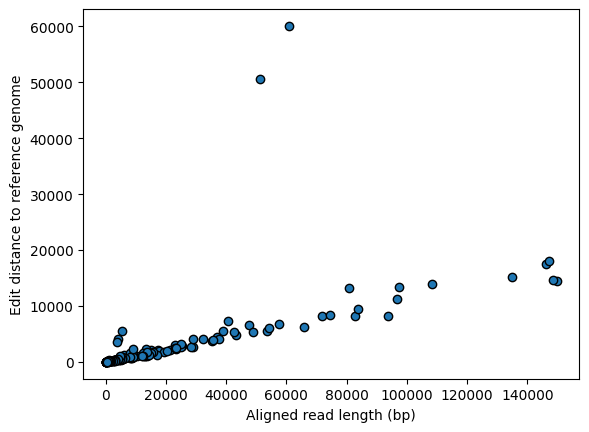

In [13]:
import matplotlib.pyplot as plt

edit_distances = []
matched_query_lengths = []

for read in reads_aligned:
    edit_distances.append(reads_aligned[read]['aln']['editDistance'])
    matched_query_lengths.append(len(reads_aligned[read]['seq']))
print()


plt.scatter(matched_query_lengths, edit_distances, edgecolors='black')
plt.xlabel("Aligned read length (bp)")
plt.ylabel("Edit distance to reference genome")
plt.show()

Alignment looks ok, lets try to create a BAMfile as output

In [16]:
def reverse_cigar(cigarstring): 
    cigar_instructions = []
    n = ""

    for c in cigarstring:
        if c.isnumeric():
            n += c
        else:
            cigar_instructions.append(n +c)
            n = ""

    return "".join(cigar_instructions[::-1])


In [17]:
b = pysam.AlignmentFile(bam, "rb")

with pysam.AlignmentFile(outbam, "wb", template = b) as outf:
    for read in reads_aligned:

        if reads_aligned[read]['strand'] == "+" :
            ref_start =  roi[0][1] + anchors[unique_anchor_alignments[read]]['start']
            cigarstring = reads_aligned[read]['aln']['cigar']
            query_sequence = reads_aligned[read]['seq']
        else:
            ref_start = roi[0][1] + anchors[unique_anchor_alignments[read]]['end'] - reads_aligned[read]['ref_length']
            cigarstring = reverse_cigar(reads_aligned[read]['aln']['cigar'])
            query_sequence = reads_aligned[read]['seq'][::-1]
        a = pysam.AlignedSegment()
        a.query_name = read
        a.query_sequence = query_sequence
        a.flag = 0 if reads_aligned[read]['strand'] == "+" else 16
        a.reference_id = reads[read]['reference_id']
        a.reference_start = ref_start
        a.mapping_quality = 30 #Could be adjusted by edit distance ranges
        a.cigarstring = cigarstring
        a.query_qualities = reads_aligned[read]['query_qualities']
        a.tags = reads[read]['tags']

        outf.write(a)

b.close()

In [18]:
pysam.sort("-o", outbam_sorted, outbam)
pysam.index(outbam_sorted)

''

In [19]:
coverages = anchors

for anchor in coverages:
    coverages[anchor]['cov'] = [0]*(roi[0][2] - roi[0][1])

for read in reads_aligned:
    
    if reads_aligned[read]['strand'] == "+" :
        start =  coverages[unique_anchor_alignments[read]]['start']
        end = start + reads_aligned[read]['ref_length']
    else:
        end = coverages[unique_anchor_alignments[read]]['end']
        start = end - reads_aligned[read]['ref_length']    
    
    #print(coverages[unique_anchor_alignments[read]]['cov'])
    for i,n in enumerate(coverages[unique_anchor_alignments[read]]['cov']):
       coverages[unique_anchor_alignments[read]]['cov'][i] = n+1 if start <= i <= end else n


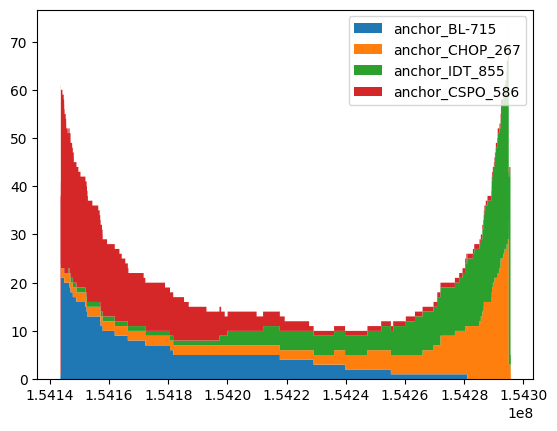

In [20]:
x = range(roi[0][1],roi[0][2])

values = []
labels = []

for i, anchor in enumerate(coverages.keys()):
    values.append(coverages[anchor]['cov'])
    labels.append(anchor)

plt.stackplot(x, values, step='pre', labels=labels)
plt.legend()
plt.show()
